# Logical Error Rate

In [1]:
code: str = "bb(n=72,k=12,d=6)"
noise: str = "depolarize(p=0.02)"

slurm_maximum_jobs = 1800
slurm_cores_per_node: int = 12  # (slurm_maximum_jobs // slurm_cores_per_node) should not exceed 200
slurm_mem_per_job: int = 4  # 4GB per job because we have very large instances
slurm_extra = dict(
    walltime = "1-00:00:00",  # adaptively shutdown if no more jobs
    queue = "scavenge",  # use with caution: dask does not seem to handle scavenge workers well
    job_extra_directives = ["--requeue"],  # use with scavenge partition will help spawn scavenged jobs
)

json_filename: str | None = None
force_finished: bool = True  # only plot the figure and do not run experiments

In [2]:
ecr_vec: list[float] = [0.2 * e for e in range(5)] + [0.9, 0.95, 0.98, 1]  # erasure conversion rate
c_vec = [0, 50, 1000]
max_iter_vec = [0, 5]
osd_order_vec = [0, 10]

mwpf_decoder_vec = [f"mwpf(c={c})" for c in c_vec] + [f"mwpf(c={c},pass_circuit=1)" for c in c_vec]
bposd0_decoder_vec = [f"bposd(max_iter={max_iter})" for max_iter in max_iter_vec]
bposdn_decoder_vec = [f"bposd(max_iter={max_iter},osd_order={osd_order},osd_method=osd_e)" for max_iter in max_iter_vec for osd_order in osd_order_vec]
bpuf_decoder_vec = [f"bpuf(max_iter={max_iter})" for max_iter in max_iter_vec]

decoder_vec = mwpf_decoder_vec + bposd0_decoder_vec + bposdn_decoder_vec + bpuf_decoder_vec + ["mwpm"]
print("number of decoders:", len(decoder_vec))

number of decoders: 15


In [3]:
from slugify import slugify
from dotmap import DotMap as dmap

if json_filename is None:
    json_filename = "zdat-" + slugify(code) + ".json"
print(json_filename)

zdat-bb-n-72-k-12-d-6.json


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from qec_lego_bench.hpc.monte_carlo import *
from qec_lego_bench.hpc.submitter import *
from qec_lego_bench.hpc.plotter import *
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [6]:
jobs = [MonteCarloJob(decoder, ecr, no_detectors) for decoder in decoder_vec for ecr in ecr_vec for no_detectors in [True, False]]

def monte_carlo_function(shots: int, decoder: str, ecr: float, no_detectors: bool) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(
        decoder=decoder,
        code=code,
        noise=noise,
        noise2=f"erasure_conversion(rate={ecr}" + (",no_detectors=1)" if no_detectors else ")"),
        max_shots=shots,
        max_errors=shots,
        no_progress=True,
        no_print=True,
    )
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)


print(monte_carlo_function(1000, decoder_vec[0], 0.5, True))

(1000, LogicalErrorResult(errors=1, discards=0, panic_cases=None))


### Define the strategy to submit jobs

In [7]:
min_shot_submitter = MinShotsSubmitter(shots=1000)
barrier = SubmitterBarrier()
precision_submitter = PrecisionSubmitter(
    # min_precision = None to force reach the target precision
    time_limit=100 * 3600,
    min_precision=None,
    target_precision=0.03,
)
barrier2 = SubmitterBarrier()
precision2_submitter = PrecisionSubmitter(
    # time_limit = None to give infinite time
    time_limit=None,
    min_precision=None,
    target_precision=0.03,
)


def submitter(executor: MonteCarloJobExecutor) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shot_submitter(executor)
    if barrier(executor, submit):  # previous submitter all finished
        submit += precision_submitter(executor)
    if barrier2(executor, submit):
        submit += precision2_submitter(executor)
    return submit

## The rest of the notebook runs the evaluation

Start a cluster by intelligently choose Slurm or Local cluster.

In [8]:
client_connector = SlurmClientConnector(
    slurm_maximum_jobs=slurm_maximum_jobs,
    slurm_cores_per_node=slurm_cores_per_node,
    slurm_mem_per_job=slurm_mem_per_job,
    slurm_extra=slurm_extra,
)

In [9]:
config = MonteCarloExecutorConfig()
config.max_submitted_job = max(config.max_submitted_job, 3 * slurm_maximum_jobs)
executor = MonteCarloJobExecutor(
    monte_carlo_function,
    jobs,
    config=config,
    filename=json_filename,
)

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

(I have to put them in the same block as the actual execution, otherwise it won't update in VScode)

,Status,JobKey,Job,Finished,Pending,Submitted,0 jobs,Total,Duration,Errors,Discards,Panics,Error Rate
0,pending,68ac0f,"Job(mwpm, 0.4, True)",4 (0%),996 (99%),0 (0%),0 (0%),1000,0.7s (0.0min),0,0,0,0.0(0)
1,pending,a8f959,"Job(mwpm, 0.6000000000000001, True)",4 (0%),996 (99%),0 (0%),0 (0%),1000,0.6s (0.0min),0,0,0,0.0(0)
2,pending,4fb40e,"Job(mwpm, 0.6000000000000001, False)",4 (0%),996 (99%),0 (0%),0 (0%),1000,0.6s (0.0min),0,0,0,0.0(0)
3,pending,a4d7cb,"Job(mwpm, 0.0, True)",3 (0%),997 (99%),0 (0%),0 (0%),1000,0.6s (0.0min),0,0,0,0.0(0)
4,pending,b61ae5,"Job(mwpm, 0.4, False)",2 (0%),998 (99%),0 (0%),0 (0%),1000,0.5s (0.0min),0,0,0,0.0(0)
5,pending,d62fb0,"Job(mwpm, 0.95, False)",4 (0%),996 (99%),0 (0%),0 (0%),1000,0.5s (0.0min),0,0,0,0.0(0)
6,pending,151214,"Job(mwpm, 0.8, False)",4 (0%),996 (99%),0 (0%),0 (0%),1000,0.5s (0.0min),0,0,0,0.0(0)
7,pending,efdc32,"Job(mwpm, 1, True)",2 (0%),998 (99%),0 (0%),0 (0%),1000,0.4s (0.0min),0,0,0,0.0(0)
8,pending,263b33,"Job(mwpm, 0.8, True)",2 (0%),998 (99%),0 (0%),0 (0%),1000,0.4s (0.0min),0,0,0,0.0(0)
9,pending,370653,"Job(mwpm, 0.0, False)",2 (0%),998 (99%),0 (0%),0 (0%),1000,0.4s (0.0min),0,0,0,0.0(0)


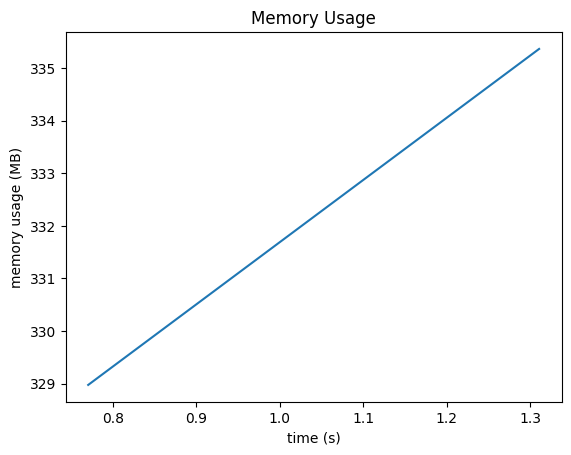

,Status,JobKey,Job,Finished,Pending,Submitted,0 jobs,Total,Duration,Errors,Discards,Panics,Error Rate
0,finished,9eeb9a,"Job(bposd(max_iter=0), 0.0, False)",331407 (100%),0 (0%),0 (0%),0 (0%),331407,51.2s (0.9min),7504,0,0,0.0226(7)
1,finished,8d955d,"Job(bposd(max_iter=0), 0.0, True)",335904 (100%),0 (0%),0 (0%),0 (0%),335904,51.0s (0.9min),7398,0,0,0.0220(7)
2,finished,d94e2b,"Job(bposd(max_iter=0), 0.2, False)",29584000 (100%),0 (0%),0 (0%),0 (0%),29584000,5990.6s (99.8min),12693,0,0,0.00043(1)
3,finished,e71722,"Job(bposd(max_iter=0), 0.2, True)",325098 (100%),0 (0%),0 (0%),0 (0%),325098,49.1s (0.8min),7454,0,0,0.0229(7)
4,finished,44841b,"Job(bposd(max_iter=0), 0.4, False)",33726652 (100%),0 (0%),0 (0%),0 (0%),33726652,7596.7s (126.6min),7434,0,0,0.000220(7)
5,finished,80b7a0,"Job(bposd(max_iter=0), 0.4, True)",339100 (100%),0 (0%),0 (0%),0 (0%),339100,51.5s (0.9min),7417,0,0,0.0219(6)
6,finished,eda015,"Job(bposd(max_iter=0), 0.6000000000000001, False)",118336000 (100%),0 (0%),0 (0%),0 (0%),118336000,28233.6s (470.6min),12950,0,0,0.000109(2)
7,finished,8d2750,"Job(bposd(max_iter=0), 0.6000000000000001, True)",325880 (100%),0 (0%),0 (0%),0 (0%),325880,48.9s (0.8min),7416,0,0,0.0228(7)
8,finished,11a515,"Job(bposd(max_iter=0), 0.8, False)",118336000 (100%),0 (0%),0 (0%),0 (0%),118336000,36550.2s (609.2min),7425,0,0,6.3(2)e-05
9,finished,35eed9,"Job(bposd(max_iter=0), 0.8, True)",333486 (100%),0 (0%),0 (0%),0 (0%),333486,55.6s (0.9min),7499,0,0,0.0225(7)


will shut down the cluster after job finishes; if this is not desired, set `shutdown_cluster` to False


In [10]:
import time  # add some sleep to let them work properly in VScode Jupyter notebook

time.sleep(0.2)
progress_plotter = JobProgressPlotter()
time.sleep(0.2)
memory_plotter = MemoryUsagePlotter()
time.sleep(0.2)
progress_plotter_by_name = JobProgressPlotter(sort_by_name=True)
time.sleep(0.2)


def callback(executor: MonteCarloJobExecutor):
    progress_plotter(executor)
    time.sleep(0.1)
    progress_plotter_by_name(executor)
    time.sleep(0.1)
    memory_plotter(executor)
    time.sleep(0.1)

print(
    "will shut down the cluster after job finishes; if this is not desired, set `shutdown_cluster` to False"
)

executor.execute(
    client_connector=client_connector,
    submitter=submitter,
    loop_callback=callback,
    shutdown_cluster=True,
    force_finished=force_finished,
)